In [278]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [279]:
# importing data
df = pd.read_csv('../data/preprocessed_train.csv')

df = df[(df["Open"] != 0) & (df['Sales'] != 0)]
df['Date'] = pd.to_datetime(df['Date'])


sales = df[df.Store == 1].loc[:, ['Date', 'Sales', 'StateHoliday', 'SchoolHoliday', 'Promo']]
sales = sales.rename(columns={'Date': 'ds', 'Sales': 'y'})

sales = sales.sort_values(by='ds', ascending=True)

C:\Users\jerry\AppData\Local\Temp\ipykernel_27184\1298720368.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/preprocessed_train.csv')


In [280]:
sales.head()

,ds,y,StateHoliday,SchoolHoliday,Promo
1014980,2013-01-02,5530,0,1,0
1013865,2013-01-03,4327,0,1,0
1012750,2013-01-04,4486,0,1,0
1011635,2013-01-05,4997,0,1,0
1009405,2013-01-07,7176,0,1,1


In [281]:
unique_state_holidays = sales['StateHoliday'].unique()
unique_state_holidays

array(['0', 0], dtype=object)

In [282]:
# replace all the unique holiday values to fit the model
sales['StateHoliday'] = sales['StateHoliday'].replace({'a': 1, 'b': 1, 'c': 1, '0': 0, 0: 0})

In [283]:
# create dataframe
state_holiday_df = pd.DataFrame({
    'holiday': 'state_holiday',
    'ds': sales[sales['StateHoliday'] == 1]['ds'],
    'lower_window': 0,
    'upper_window': 1
})

school_holiday_df = pd.DataFrame({
    'holiday': 'school_holiday',
    'ds': sales[sales['SchoolHoliday'] == 1]['ds'],
    'lower_window': 0,
    'upper_window': 1
})

promo_df = pd.DataFrame({
    'holiday': 'promo',
    'ds': sales[sales['Promo'] == 1]['ds'],
    'lower_window': 0,
    'upper_window': 0
})

holidays = pd.concat([state_holiday_df, school_holiday_df, promo_df])

In [284]:
split_index = int(len(sales) * 0.8)
train = sales.iloc[:split_index]
test = sales.iloc[split_index:]

In [285]:
train.head()

,ds,y,StateHoliday,SchoolHoliday,Promo
1014980,2013-01-02,5530,0,1,0
1013865,2013-01-03,4327,0,1,0
1012750,2013-01-04,4486,0,1,0
1011635,2013-01-05,4997,0,1,0
1009405,2013-01-07,7176,0,1,1


In [286]:
test.head()

,ds,y,StateHoliday,SchoolHoliday,Promo
210735,2015-01-23,3586,0,0,0
209620,2015-01-24,4840,0,0,0
207390,2015-01-26,4781,0,0,1
206275,2015-01-27,4806,0,0,1
205160,2015-01-28,4310,0,0,1


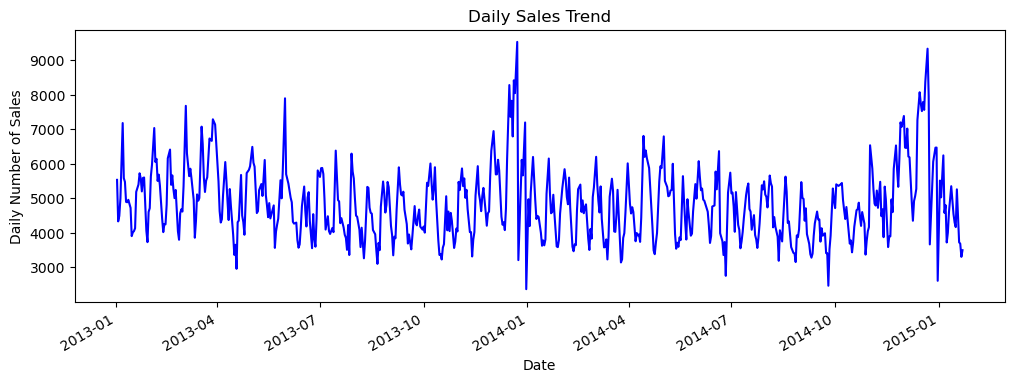

In [287]:
# # plot daily sales
ax = train.set_index('ds')['y'].plot(figsize=(12, 4), color='blue')
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
ax.set_title('Daily Sales Trend')
plt.show()

In [288]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet_model = Prophet(interval_width=0.95, holidays=holidays)
prophet_model.fit(train)

# dataframe that extends to next year
future_dates = prophet_model.make_future_dataframe(periods = 90)

01:28:25 - cmdstanpy - INFO - Chain [1] start processing
01:28:26 - cmdstanpy - INFO - Chain [1] done processing


In [289]:
# predictions
forecast = prophet_model.predict(future_dates)

In [290]:
# get prediction value for compare
predicted = forecast[['ds', 'yhat']].set_index('ds')

In [291]:
test_filtered = test[test['ds'].isin(predicted.index)]

In [292]:
mse = mean_squared_error(test_filtered['y'], predicted.loc[test_filtered['ds'], 'yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_filtered['y'], predicted.loc[test_filtered['ds'], 'yhat'])

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 453139.80037662137
RMSE: 673.1565942458125
MAE: 547.3737567527875


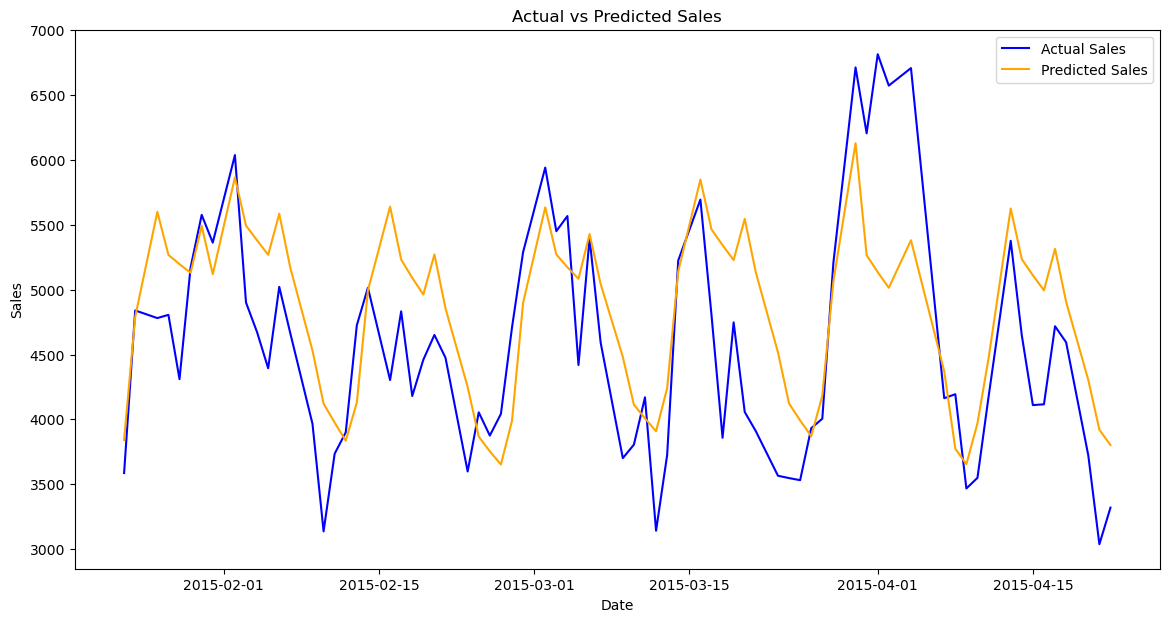

In [293]:
plt.figure(figsize=(14, 7))
plt.plot(test_filtered['ds'], test_filtered['y'], label='Actual Sales', color='blue')
plt.plot(predicted.loc[test_filtered['ds']].index, predicted.loc[test_filtered['ds'], 'yhat'], label='Predicted Sales', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

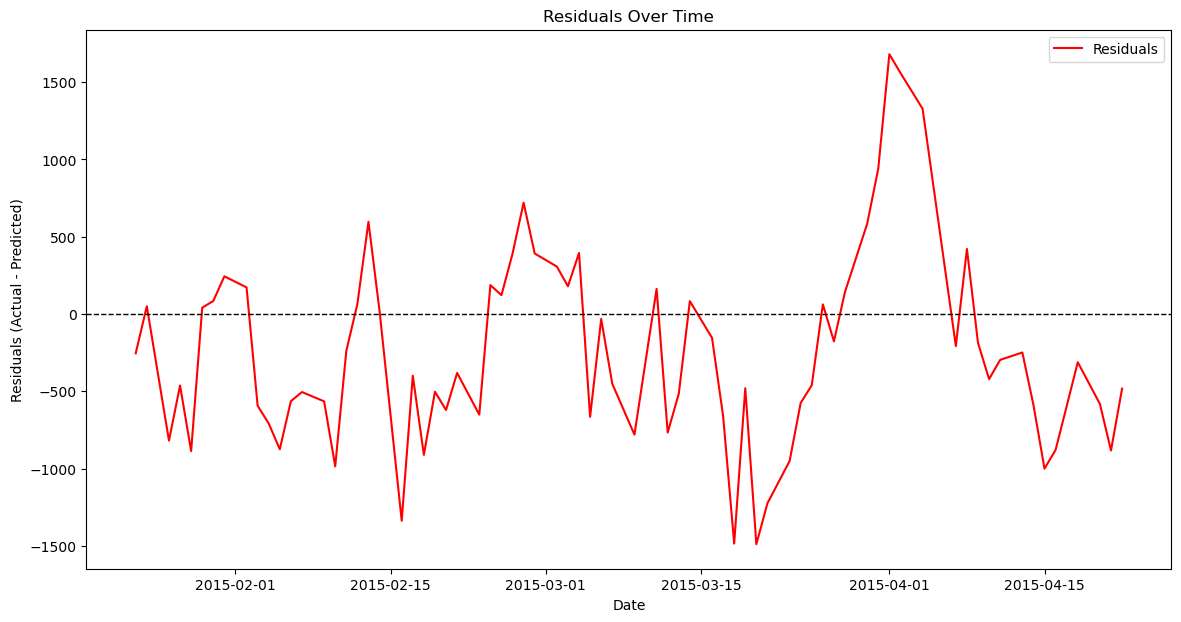

In [294]:
residuals = test_filtered['y'].values - predicted.loc[test_filtered['ds'], 'yhat'].values
plt.figure(figsize=(14, 7))
plt.plot(test_filtered['ds'], residuals, label='Residuals', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.show()

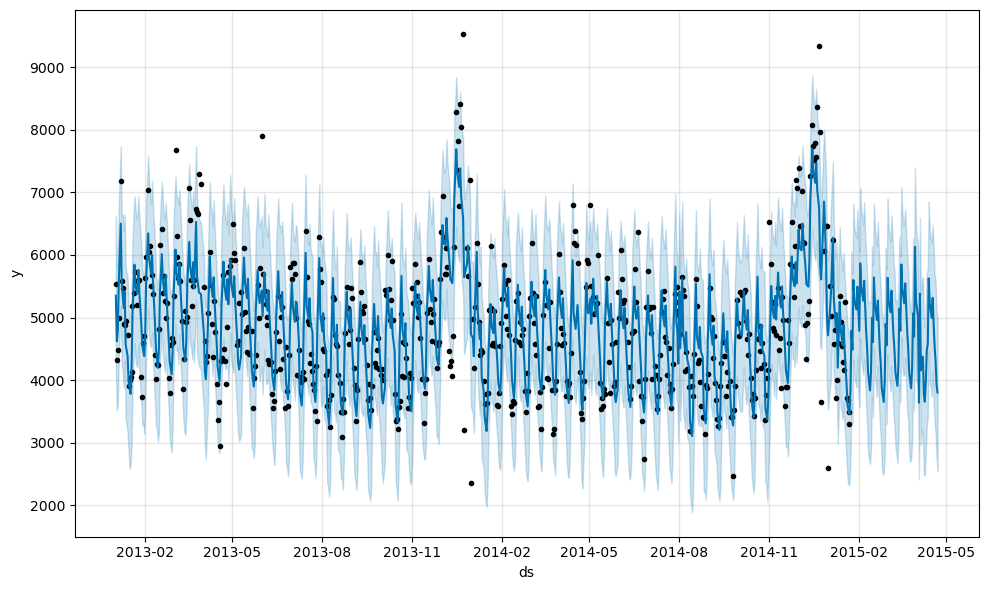

In [295]:
prophet_model.plot(forecast)
plt.show()

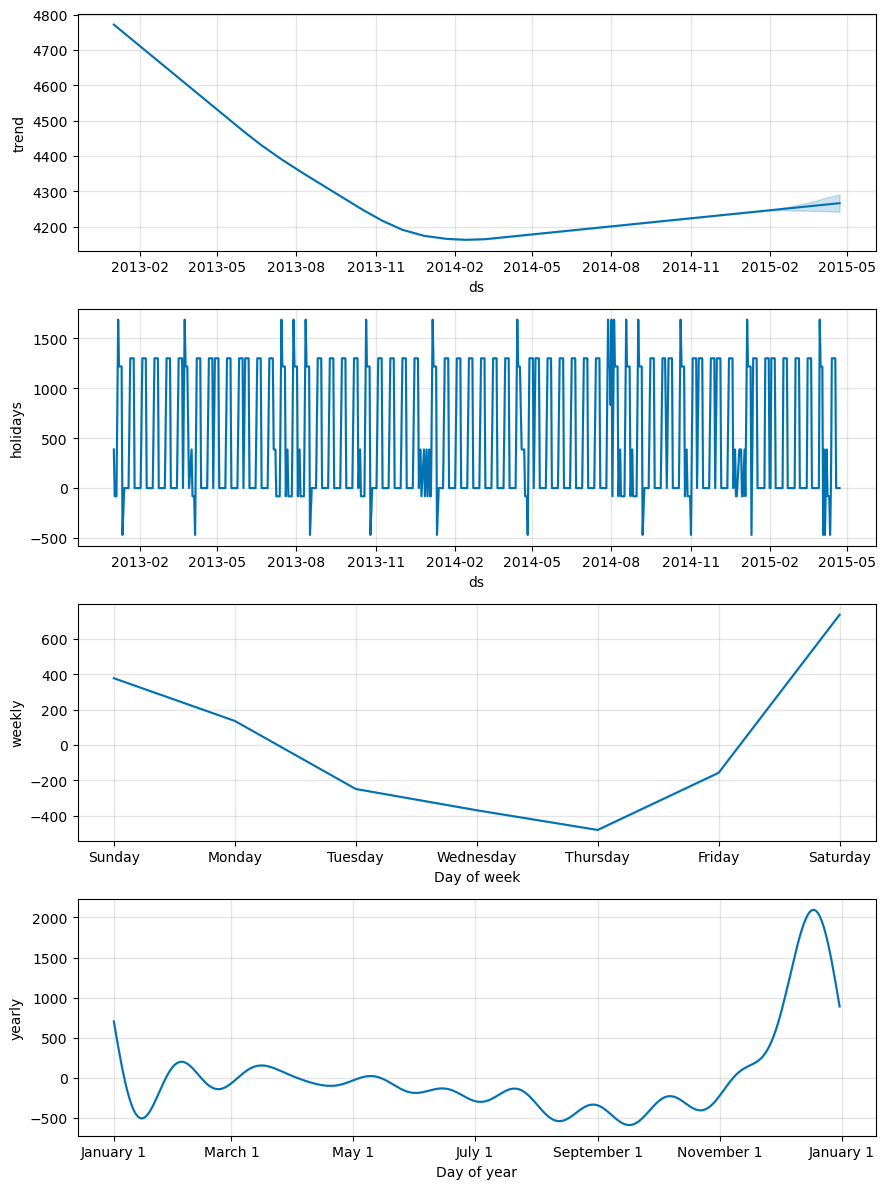

In [296]:
prophet_model.plot_components(forecast)
plt.show()